# The Premium (Level 2 Model)

In this model, we used the raw dataset from training.csv. The difference of this premium model from the Base Model is we using more features and do feature engineering for timestamp data (hour and weekday).

The features we use for this "Premium Model":
* 'ProductId', (dummy variable)
* 'ChannelId', (dummy variable)
* 'weekday',(cycling sin cos timestamp)
* 'hour', (cycling sin cos timestamp)
* 'PricingStrategy', (dummy variable)
* 'ProviderId', (dummy variable)
* Amount



# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, matthews_corrcoef
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics, preprocessing, model_selection
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings

from sklearn.linear_model import LogisticRegression

# Set random seed 
RSEED = 42

# Import raw training.csv dataset

In [2]:
#import data

df = pd.read_csv("data/training.csv")

In [3]:
df.shape

(95662, 16)

# Transforming Date & Create hour & weekday columns

In [4]:
# to replace and remove value T and Z in column
df["TransactionStartTime"] = [c.replace("T", " ") for c in df["TransactionStartTime"]] #replace T with blank space
df["TransactionStartTime"] = [c.replace("Z", "") for c in df["TransactionStartTime"]] # remove z

In [5]:
# Change "TransactionStartTime" into Datetime format 
df["TransactionStartTime"] = pd.to_datetime(df["TransactionStartTime"], infer_datetime_format = True)

In [6]:
df["hour"] = df["TransactionStartTime"].dt.hour
df["weekday"] = df["TransactionStartTime"].dt.weekday

# Cycling Hour & Weekday (Sin Cos)

In [7]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/23.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/23.0)

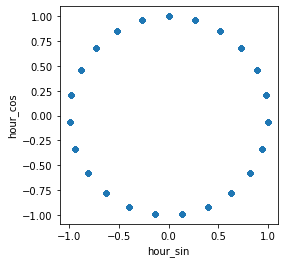

In [8]:
ax = df.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

In [9]:
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/6.0)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/6.0)

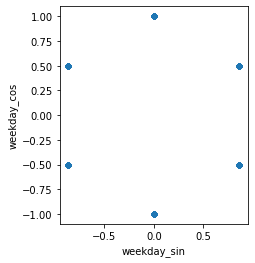

In [10]:
ax = df.plot.scatter('weekday_sin', 'weekday_cos').set_aspect('equal')

# Get Dummies Variables

In [11]:
# import make_dummies function from python script
from scripts.functions import make_dummies

In [12]:
# listing the features for One-hot-encoding

ls = ['ProductId', 'ChannelId','PricingStrategy', 'ProviderId']

# creating dummies, this function will automatically delete the original column
df = make_dummies(df, ls)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   TransactionId         95662 non-null  object        
 1   BatchId               95662 non-null  object        
 2   AccountId             95662 non-null  object        
 3   SubscriptionId        95662 non-null  object        
 4   CustomerId            95662 non-null  object        
 5   CurrencyCode          95662 non-null  object        
 6   CountryCode           95662 non-null  int64         
 7   ProductCategory       95662 non-null  object        
 8   Amount                95662 non-null  float64       
 9   Value                 95662 non-null  int64         
 10  TransactionStartTime  95662 non-null  datetime64[ns]
 11  FraudResult           95662 non-null  int64         
 12  hour                  95662 non-null  int64         
 13  weekday         

# Features Selection Before Modeling

In [14]:
#drop unimportant features

df.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProductCategory', 'Value', 'TransactionStartTime', 
        "hour", "weekday"], axis=1, inplace=True)

In [15]:
X = df.drop("FraudResult", axis = 1)
y = df.FraudResult

X.columns

Index(['Amount', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'ProductId_10', 'ProductId_11', 'ProductId_12', 'ProductId_13',
       'ProductId_14', 'ProductId_15', 'ProductId_16', 'ProductId_19',
       'ProductId_2', 'ProductId_20', 'ProductId_21', 'ProductId_22',
       'ProductId_23', 'ProductId_24', 'ProductId_27', 'ProductId_3',
       'ProductId_4', 'ProductId_5', 'ProductId_6', 'ProductId_7',
       'ProductId_8', 'ProductId_9', 'ChannelId_2', 'ChannelId_3',
       'ChannelId_5', 'PricingStrategy_1', 'PricingStrategy_2',
       'PricingStrategy_4', 'ProviderId_2', 'ProviderId_3', 'ProviderId_4',
       'ProviderId_5', 'ProviderId_6'],
      dtype='object')

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10, stratify = y)

X_train.shape
X_test.shape

(28699, 38)

# TAKEN M2 Modeling Using XGBoost

[09:54:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.90      0.76      0.82        58

    accuracy                           1.00     28699
   macro avg       0.95      0.88      0.91     28699
weighted avg       1.00      1.00      1.00     28699

acc: 0.9993379560263423
mcc: 0.8250351717738527
Confusion matrix, without normalization
[[28636     5]
 [   14    44]]


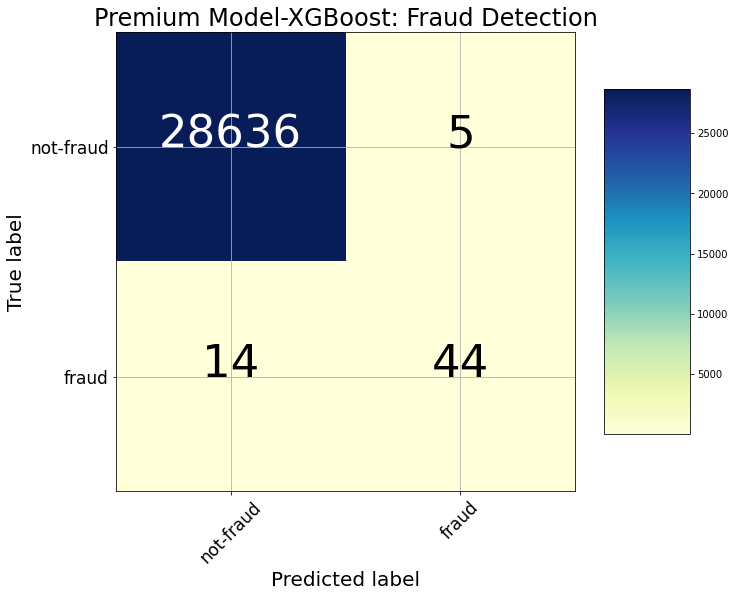

In [17]:
xgb = XGBClassifier(use_label_encoder = False, n_estimators = 100)
test = xgb.fit(X_train, y_train)

# Make predictions on test set 
y_pred = xgb.predict(X_test)

# Evaluate your model 
cm = confusion_matrix(y_test, y_pred)

#classification Report

report = classification_report(y_test, y_pred)
print(report)

accuracy = accuracy_score(y_test, y_pred)
print(f"acc: {accuracy}")

mcc = matthews_corrcoef(y_test, y_pred)
print(f"mcc: {mcc}")


#import function from python scripts
from scripts.confusion_matrix import plot_confusion_matrix 

plot_confusion_matrix(cm, classes = ['not-fraud', 'fraud'], cmap='YlGnBu', title = "Premium Model-XGBoost: Fraud Detection")
#sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# M2 Modeling Using KNN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.78      0.74      0.76        58

    accuracy                           1.00     28699
   macro avg       0.89      0.87      0.88     28699
weighted avg       1.00      1.00      1.00     28699

acc: 0.9990592006690129
mcc: 0.7608601972977721
Confusion matrix, without normalization
[[28629    12]
 [   15    43]]


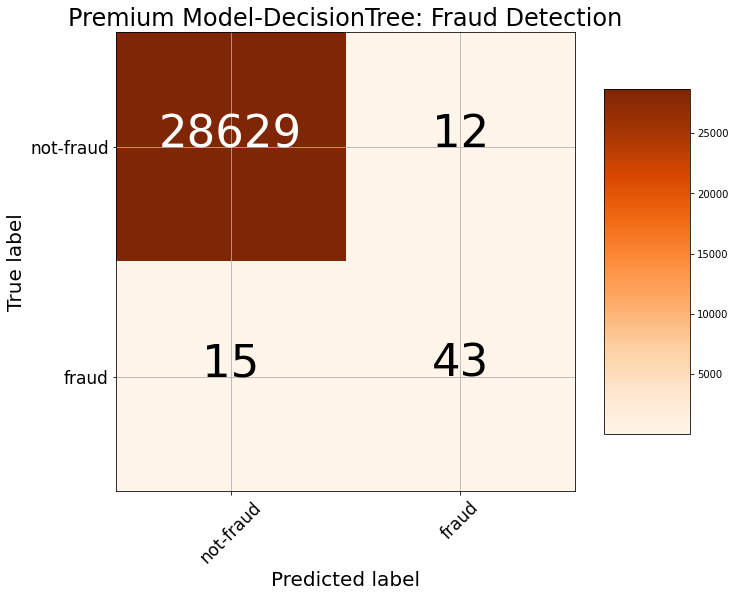

In [18]:
dtc = DecisionTreeClassifier(random_state=RSEED)

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

# Evaluate your model 
cm = confusion_matrix(y_test, y_pred)

#classification Report
report = classification_report(y_test, y_pred)
print(report)

accuracy = accuracy_score(y_test, y_pred)
print(f"acc: {accuracy}")

mcc = matthews_corrcoef(y_test, y_pred)
print(f"mcc: {mcc}")


from scripts.confusion_matrix import plot_confusion_matrix #import function from script

plot_confusion_matrix(cm, classes = ['not-fraud', 'fraud'], title = "Premium Model-DecisionTree: Fraud Detection");